In [1]:
import time
import pandas as pd
import numpy as np
from scipy.stats import uniform

from sklearn.model_selection import GroupKFold, GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Import helperfunctions
from ML_functions import fun_load_settings, fun_load_data, fun_preprocessing, fun_fit_tuning
from ML_functions import fun_convert_time
from ML_functions import fun_scaled_neg_MAPE, fun_tuning_results, fun_load_best_params, fun_scores
from ML_functions import plot_feature_weights

# Set the default optimization problem for the case of manual executing the script (choose either "TSP" or "CVRP")
default_optimization_problem = "TSP"

# Call the function to define optimization_problem based on how the notebook is executed
# If the notebook is run by the script "main.ipynb", load optimization_problem from "settings.json". Otherwise use the default optimization problem from above
optimization_problem = fun_load_settings(default_optimization_problem)

# Load data and start the time count for the script within the function fun_load_data
data, start_script = fun_load_data(optimization_problem)

# Do the train test split during the preprocessing
X_train, X_test, y_train, y_test, train_data = fun_preprocessing(data, train_size=0.8)

The notebook is executed directly. :)
Optimization Problem: 'TSP'


# **Ensebmles of Decision Trees**
### **1. Random Forest**
- the maximum number of features for the TSP is 38
- the maximum number of features for the CVRP is 43
- use n_jobs=-1 only in the outer process (grid search cross-validation) and not also in the RandomForestRegressor.

In [2]:
# Randomized search cross validation
if (optimization_problem == "TSP"):
    param_distr = {"max_features": list(np.arange(15, 35, 5)) + [None], 
                   "max_depth": range(10, 26),
                   "max_leaf_nodes": list(range(2000, 4000, 500)) + [None],
                   "min_samples_leaf": range(1, 26),
                   "min_samples_split": range(2, 21),
                   "min_impurity_decrease": [0.0001, 0.001]}

elif (optimization_problem == "CVRP"):
    param_distr = {"max_features": list(np.arange(15, 40, 5)) + [None], 
                   "max_depth": range(10, 26),
                   "max_leaf_nodes": list(range(3000, 5000, 500)) + [None],
                   "min_samples_leaf": range(1, 26),
                   "min_samples_split": range(2, 21),
                   "min_impurity_decrease": [0.0001, 0.001]}

random_search = RandomizedSearchCV(estimator=RandomForestRegressor(n_estimators=50, bootstrap=True, random_state=42), 
                                        param_distributions=param_distr, 
                                        cv=GroupKFold(n_splits=3).split(X_train, y_train, groups=X_train["Instance ID"]), 
                                        n_iter=50, scoring=fun_scaled_neg_MAPE, 
                                        refit=False, n_jobs=-1, random_state=42, verbose=True)
tuning_details = fun_fit_tuning(random_search, X_train, y_train, file_name=optimization_problem + "_RF")

# View results of grid search cross validation
model_results_dict = fun_scores(random_search, X_train, y_train)
model_results_dict.update(tuning_details)

# Create a dictionary to store the results
results_dict = {"Random Forest (RGS)": model_results_dict}

# View grid search CV scores of all parameter combinations
results_df = fun_tuning_results(random_search, param_distr)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'Parameter combinations': 50,
 'Total tuning time': '25m, 32s',
 'Grid search total fit time': '1h, 38m',
 'Grid search total prediction time': '20s'}

CV MAPE (scaled) train data:  8.0291 %


**Best model / parameter combination:**

{'min_samples_split': 11,
 'min_samples_leaf': 6,
 'min_impurity_decrease': 0.0001,
 'max_leaf_nodes': None,
 'max_features': 25,
 'max_depth': 13}

**Cross validation scores of different parameter combinations:**

,max_features,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split,min_impurity_decrease,mean_test_score,converted_mean_fit_time
0,25,13,None,6,11,0.0001,-0.080291,"1m, 52s"
1,30,13,3000,6,5,0.0001,-0.080541,"2m, 38s"
2,30,17,None,1,6,0.0010,-0.081131,"2m, 33s"
3,30,15,None,4,7,0.0010,-0.081358,"2m, 47s"
4,30,25,None,6,3,0.0010,-0.081557,"2m, 44s"
5,30,14,2500,4,13,0.0001,-0.081758,"2m, 50s"
6,None,19,3500,11,8,0.0001,-0.081986,"2m, 48s"
7,30,23,None,15,5,0.0001,-0.082063,"2m, 6s"
8,20,18,None,1,18,0.0010,-0.082479,"1m, 36s"
9,30,12,None,10,6,0.0001,-0.082554,"2m, 7s"


**Create a new model with best parameter combination and more trees**

{'min_samples_split': 11,
 'min_samples_leaf': 6,
 'min_impurity_decrease': 0.0001,
 'max_leaf_nodes': None,
 'max_features': 25,
 'max_depth': 13}

CV MAPE (scaled) train data:  7.959 %
CV RMSE (scaled) train data: 2.3763
CV computation time: 1m, 1s


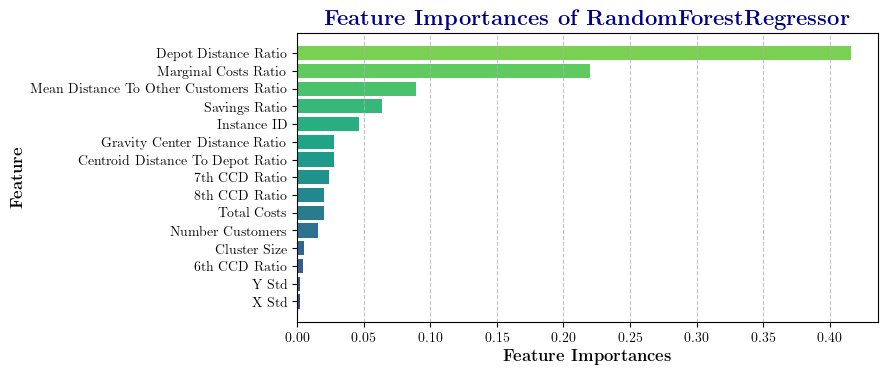

In [5]:
# Load best parameters of the model
best_params = fun_load_best_params(optimization_problem, model_abbreviation= "RF")

# Train new model with best parameter combination and more trees
forest = RandomForestRegressor(n_estimators=100, **best_params, random_state=42, n_jobs=-1)

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
model_results_dict = fun_scores(forest, X_train, y_train)

# Save results to dictionary
results_dict["Random Forest (Best model, more trees)"] = model_results_dict

# View feature importances
plot_feature_weights(model=forest.fit(X_train, y_train), n_features=15)

### **2. Gradient Boosting Regression Trees**
- a lower learning rate requires more trees

In [4]:
if (optimization_problem == "TSP"):
    
    # Randomized search cross validation
    param_distr = {"n_estimators": range(80, 140, 20), 
                   "max_features": list(np.arange(15, 35, 5)) + [None], # "sqrt" and "log2" did not perform 
                   "learning_rate": [0.01, 0.05, 0.1, 0.3], # Or uniform(0, 0.3)
                   "max_depth": range(5, 26),
                   "max_leaf_nodes": list(range(500, 2500, 500)) + [None],
                   "min_samples_leaf": range(1, 26),
                   "min_samples_split": range(2, 21)}
  
    random_search = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_distributions=param_distr, 
                                            cv=GroupKFold(n_splits=3).split(X_train, y_train, groups=X_train["Instance ID"]),
                                            n_iter=25, scoring=fun_scaled_neg_MAPE, 
                                            refit=False, n_jobs=-1, random_state=42, verbose=True)
    tuning_details = fun_fit_tuning(random_search, X_train, y_train, file_name=optimization_problem + "_GBRT")

    # View results of grid search cross validation
    model_results_dict = fun_scores(random_search, X_train, y_train)
    model_results_dict.update(tuning_details)

    # Save results to dictionary
    results_dict["Gradient Boosting Regression Trees (RGS)"] = model_results_dict

    # View grid search CV scores of all parameter combinations
    results_df = fun_tuning_results(random_search, param_distr)

else: print("This cell is only executed for the TSP!")

Fitting 3 folds for each of 25 candidates, totalling 75 fits


{'Parameter combinations': 25,
 'Total tuning time': '34m, 7s',
 'Grid search total fit time': '2h, 9m',
 'Grid search total prediction time': '10s'}

CV MAPE (scaled) train data:  6.1202 %


**Best model / parameter combination:**

{'n_estimators': 120,
 'min_samples_split': 6,
 'min_samples_leaf': 23,
 'max_leaf_nodes': 1500,
 'max_features': 25,
 'max_depth': 10,
 'learning_rate': 0.1}

**Cross validation scores of different parameter combinations:**

,n_estimators,max_features,learning_rate,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split,mean_test_score,converted_mean_fit_time
0,120,25,0.10,10,1500,23,6,-0.061202,"5m, 43s"
1,120,25,0.10,12,None,24,3,-0.061592,"6m, 46s"
2,80,20,0.10,19,500,21,5,-0.061604,"4m, 0s"
3,100,15,0.10,23,500,14,2,-0.062221,"3m, 46s"
4,120,None,0.05,18,500,3,17,-0.062250,"10m, 15s"
5,100,20,0.10,14,1000,3,13,-0.062658,"5m, 4s"
6,100,20,0.10,25,1500,7,16,-0.063592,"6m, 21s"
7,100,25,0.05,22,1000,19,3,-0.063808,"6m, 9s"
8,100,25,0.05,19,1000,4,12,-0.064767,"4m, 41s"
9,120,30,0.10,25,2000,2,12,-0.065887,"11m, 27s"


### **3. Extreme Gradient Boosting: XGBoost-Package**

Fitting 3 folds for each of 54 candidates, totalling 162 fits


{'Search type': 'GridSearchCV',
 'Parameter combinations': 54,
 'Total tuning time': '23m, 34s',
 'Total tuning fit time': '1h, 27m',
 'Total tuning prediction time': '2m, 21s'}

CV MAPE (scaled) train data:  5.4142 %


**Best model / parameter combination:**

{'colsample_bytree': 1.0,
 'learning_rate': 0.05,
 'max_depth': 7,
 'subsample': 0.6}

**Cross validation scores of different parameter combinations:**

,max_depth,learning_rate,subsample,colsample_bytree,mean_test_score,converted_mean_fit_time
0,7,0.05,0.6,1.0,-0.054142,"1m, 29s"
1,7,0.05,0.8,1.0,-0.054473,"1m, 27s"
2,7,0.05,0.8,0.8,-0.054966,"1m, 17s"
3,7,0.10,0.8,1.0,-0.055028,"1m, 28s"
4,9,0.05,0.6,1.0,-0.055130,"3m, 44s"
5,7,0.05,0.6,0.8,-0.055243,"1m, 18s"
6,7,0.05,1.0,1.0,-0.055355,"1m, 19s"
7,7,0.05,0.8,0.6,-0.055452,54s
8,7,0.10,1.0,1.0,-0.055491,"1m, 19s"
9,9,0.05,0.8,1.0,-0.055517,"3m, 49s"


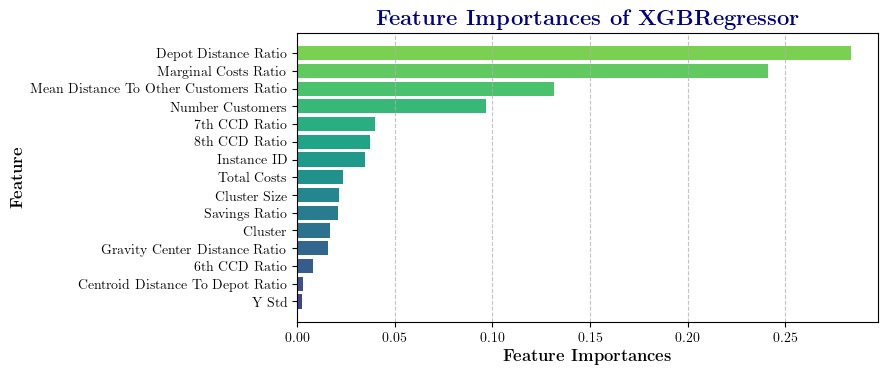

In [6]:
# Grid search cross validation
param_grid = {"max_depth": [5, 7, 9], # 12 did not perform
              "learning_rate": [0.05, 0.1], # 0.01 did not perform
              "subsample": [0.6, 0.8, 1.0], # 0.4 did not perform
              "colsample_bytree": [0.6, 0.8, 1.0]}
    
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(n_estimators=750, objective="reg:squarederror", random_state=42), 
                           param_grid=param_grid, cv=GroupKFold(n_splits=3).split(X_train, y_train, groups=X_train["Instance ID"]),
                           scoring=fun_scaled_neg_MAPE, refit=True, n_jobs=-1, verbose=True)
tuning_details = fun_fit_tuning(grid_search, X_train, y_train, file_name=optimization_problem + "_XGBoost")

# View results of grid search cross validation
model_results_dict = fun_scores(grid_search, X_train, y_train)
model_results_dict.update(tuning_details)

# Save results to dictionary
results_dict["XGBoost (GS)"] = model_results_dict

# View grid search CV scores of all parameter combinations
results_df = fun_tuning_results(grid_search, param_grid)

# View feature importances
plot_feature_weights(model=grid_search.best_estimator_, n_features=15)

# **Compare Results**

In [6]:
display(pd.DataFrame(results_dict).sort_values(by="MAPE", axis=1))
print("Total script computation time:", fun_convert_time(start=start_script, end=time.time()))

,XGBoost (GS),Gradient Boosting Regression Tree (RGS),"Random Forest (Best model, more trees)",Random Forest (RGS)
MAPE,5.4142,6.1202,7.959,8.0291
RMSE,None,None,2.3763,None
CV computation time,None,None,"1m, 1s",None
Parameter combinations,54,25,NaN,50
Total tuning time,"16m, 35s","34m, 7s",NaN,"25m, 32s"
Grid search total fit time,"1h, 2m","2h, 9m",NaN,"1h, 38m"
Grid search total prediction time,"1m, 31s",10s,NaN,20s


Total script computation time: 1h, 18m
